In [1]:
import numpy as np
import cv2
from PIL import Image
import open3d as o3d
import json
import os
from tqdm import tqdm

from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib import rcParams
from shapely.geometry import MultiPoint, box

# from pyquaternion.quaternion import Quaternion
from pyquaternion import Quaternion
import os.path as osp
from nuscenes import NuScenes

# Utils for Lidar and Radar
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import view_points, BoxVisibility
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.data_classes import RadarPointCloud
from nuscenes.scripts.export_2d_annotations_as_json import get_2d_boxes, post_process_coords
from utils import *

from typing import Tuple, List, Dict, Union

%matplotlib inline

In [2]:
nusc = NuScenes(version='v1.0-mini', dataroot='/home/gus/Documents/AI_S/nuScenes/v1_0-mini', verbose=True)
#nusc = NuScenes(version='v1.0-mini', dataroot='/home/sherlock/Documents/nuScenes/data', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.6 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


## Obtaining a simple annotation

In [3]:
# Load the information from .txt file in JSON format
#sample_path = '/home/sherlock/Documents/3d_obj_detection/anns/sample_0a0d6b8c2e884134a3b48df43d54c36a_file.txt'
sample_path = os.getcwd()+'/dataset/samples/sample_841dd6709e9b4d7c9d6bf888f1fe6d7e_file.txt'

# This is a Dictionary of lists of dictionaries
data_json = load_file(sample_path)

## Point cloud data

In [4]:
# Create instance metadata
annotation_metadata = data_json['instance'][0]

# point cloud
pointcloud_lidar = load_pcl_txt(annotation_metadata['pointcloud_path'], annotation_metadata['pcl_shape'])

# Plotting the segmented point cloud
Velopoints = np.asarray(pointcloud_lidar.T, np.float32)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Velopoints)

# visualizing the 3D point cloud
o3d.visualization.draw_geometries([pcd])

## Retrieving image

In [5]:
# Sample data from cam Sensor
cam_data = nusc.get('sample_data', annotation_metadata['camera_token'])
cam_data

{'token': '39caaccc75dd4e38b8fe6f40e81f5621',
 'sample_token': '841dd6709e9b4d7c9d6bf888f1fe6d7e',
 'ego_pose_token': '39caaccc75dd4e38b8fe6f40e81f5621',
 'calibrated_sensor_token': '9e0e1f9abcff4f02b602a96ba68cc115',
 'timestamp': 1538984249920351,
 'fileformat': 'jpg',
 'is_key_frame': True,
 'height': 900,
 'width': 1600,
 'filename': 'samples/CAM_FRONT_RIGHT/n015-2018-10-08-15-36-50+0800__CAM_FRONT_RIGHT__1538984249920351.jpg',
 'prev': '09bffbdd05374f67a62efbecdc598cad',
 'next': '41b7817b193a4f8896ff563b79ce5225',
 'sensor_modality': 'camera',
 'channel': 'CAM_FRONT_RIGHT'}

## Plotting the current image frame

(-0.5, 1599.5, 899.5, -0.5)

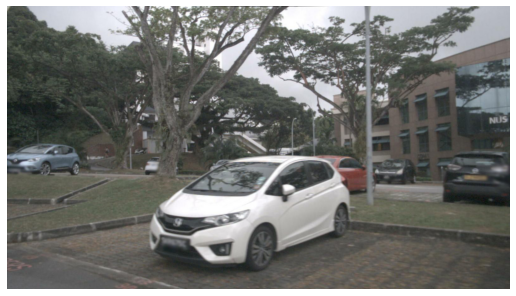

In [6]:
# Open image of the interest camera
im = Image.open(osp.join(nusc.dataroot, cam_data['filename']))

plt.figure(figsize=(9, 16))
plt.imshow(im)
plt.axis('off')

## Plotting the point cloud on the image

(-0.5, 1599.5, 899.5, -0.5)

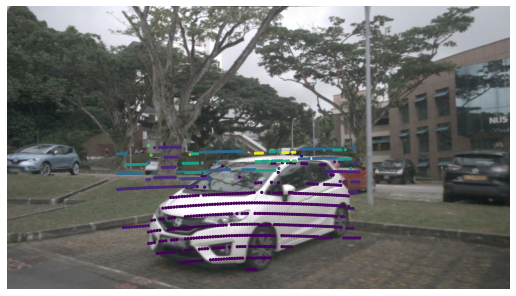

In [7]:
# point cloud
pointcloud_cam = load_pcl_txt(annotation_metadata['img_pc_path'], annotation_metadata['img_pcl_shape'])

plt.figure(figsize=(9, 16))
plt.imshow(im)
plt.scatter(pointcloud_cam[0, :], pointcloud_cam[1, :], c = pointcloud_cam[3, :], s = 5)
plt.axis('off')

## Instance segmentation K means

In [9]:
from sklearn.cluster import KMeans

# Using the Kmeans object
clustering = KMeans(n_clusters = 5).fit(pointcloud_lidar.T)
# Clusters
kmeans_clusters = clustering.labels_
kmeans_clusters

array([4, 4, 4, 3, 4, 4, 4, 3, 3, 4, 4, 3, 0, 3, 3, 4, 4, 3, 0, 0, 4, 4,
       3, 0, 0, 4, 4, 3, 0, 4, 4, 4, 0, 4, 4, 0, 0, 4, 4, 0, 0, 4, 4, 0,
       4, 4, 0, 0, 4, 3, 0, 4, 3, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 4, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 3, 2, 0, 0, 3, 2, 0, 0, 0, 0, 2, 0, 0, 3, 2, 0,
       0, 2, 2, 0, 0, 0, 3, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2,
       0, 0, 0, 2, 2, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

## Instance segmentation AgglomerativeClustering

In [10]:
from sklearn.cluster import AgglomerativeClustering

# Using the AgglomerativeClustering object
clustering = AgglomerativeClustering(n_clusters = 5).fit(pointcloud_lidar.T)
# Clusters
aglomerative_clusters = clustering.labels_
aglomerative_clusters

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 3, 1, 1, 0, 0, 1, 3, 3, 0, 0,
       1, 3, 3, 0, 0, 1, 3, 0, 0, 0, 3, 0, 1, 3, 3, 1, 1, 3, 3, 0, 0, 3,
       0, 0, 3, 3, 0, 1, 3, 0, 1, 3, 3, 3, 3, 0, 0, 3, 3, 3, 0, 0, 3, 0,
       0, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3,
       3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0,
       3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3,
       3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 0, 3,
       3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3,
       0, 3, 3, 0, 3, 3, 3, 4, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
       3, 3, 3, 4, 3, 3, 1, 2, 3, 3, 1, 2, 3, 3, 3, 3, 2, 3, 3, 1, 4, 3,
       3, 4, 4, 3, 3, 3, 1, 4, 4, 3, 3, 4, 4, 3, 3, 4, 4, 3, 3, 4, 3, 4,
       3, 3, 3, 4, 2, 1, 1, 1, 1, 1, 1, 1])

## Instance segmentation MeanShift

In [28]:
from sklearn.cluster import MeanShift

# Using the MeanShift object
clustering = MeanShift(cluster_all = False).fit(pointcloud_lidar.T)
# Clusters
meanshift_clusters = clustering.labels_
meanshift_clusters

array([ 1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  0,  1,  1,  1,
        1,  0,  0,  1,  1,  1,  0,  0,  1,  1,  1,  0,  1,  1,  1,  0,  1,
        1,  0,  0,  1,  1,  0,  0,  1,  1,  0,  1,  1,  0,  0,  1,  1,  0,
        1,  1,  0,  0,  0,  0,  1,  1,  0,  0,  0,  1,  1,  0,  1,  1,  0,
        0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
        1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,  1,  0,  0,
        0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,
        0,  0,  1,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0, -1,
        0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0, -1,  0,  0,  0, -1,  0,  0, -1,  0,  0,  0,  2,  0,  0,  0,
        0,  0,  2,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,
        0,  3,  0,  0,  0,  3,  0,  0,  0,  0,  3,  0,  0, -1,  2,  0,  0,
        2,  2,  0,  0,  0

## Instance segmentation DBSCAN

In [8]:
# Using the DBScan object
clustering = DBSCAN(eps = 2.0, min_samples = 20).fit(pointcloud_lidar.T)
# Clusters
dbscan_clusters = clustering.labels_
dbscan_clusters

array([-1, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1,
       -1, -1, -1, -1,  0, -1, -1, -1,  0, -1, -1, -1,  0, -1, -1, -1,  0,
       -1, -1, -1,  0, -1, -1, -1,  0, -1, -1,  1,  1, -1,  0, -1,  1,  1,
       -1,  0, -1, -1,  1,  1,  1,  0, -1, -1, -1,  1,  1,  1,  0, -1,  1,
        1,  1,  0,  0, -1,  0,  1,  1,  1,  0,  0,  1,  1,  1,  1,  0,  0,
        0,  1,  1,  1,  0,  0,  0,  0,  1,  1,  1,  1,  1,  0,  0,  0,  0,
        0,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,
        0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  1,  1,
        1,  1,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  0, -1,  0,  0,
        1,  1,  1,  1,  1,  1,  1,  0, -1, -1,  0,  1,  1,  1,  1,  1,  1,
        1,  1,  0, -1, -1, -1,  1,  1,  1,  1,  1,  1,  0, -1, -1, -1,  1,
        1,  1,  1,  1,  1,  1,  0, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        0, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  0, -1, -1, -1, -1,
        1,  1,  1,  1,  1

In [20]:
# Number of unique clusters and Delete -1 (noisy) class
# options: kmeans_clusters - aglomerative_clusters - meanshift_clusters - dbscan_clusters
clusters = np.delete(np.unique(dbscan_clusters), np.where(np.unique(dbscan_clusters) == -1))

# Initialize bigger cluster index
bigger_idx = 0

pcd_path =  os.getcwd()+'/dataset/pcd_segmentation/'

for class_idx, cluster in enumerate(clusters):
    # Obtain the indeces of interest of the current cluster
    idx = np.where(dbscan_clusters == class_idx)[0]
    
    # extract shape of curent bigger cluster
    bigger_pcl_temp = pointcloud_lidar.T[bigger_idx].shape[0]
            
    # updates bigger cluster index    
    if pointcloud_lidar.T[idx].shape[0] >= bigger_pcl_temp:
        bigger_idx = idx

     
# extract the point cloud of the current cluster
pcl_temp = pointcloud_lidar.T[bigger_idx]

#  and save the point cloud in pcd
Velopoints = np.asarray(pcl_temp, np.float32)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Velopoints)

# Saves the point cloud in .pcd file
o3d.io.write_point_cloud(pcd_path+'pcd_segmentation_'+annotation_metadata['annotation_token']+'.pcd', pcd)

# visualizing the 3D point cloud
o3d.visualization.draw_geometries([pcd])



## Process all pointclouds

In [8]:
# path with all the sample files
samples_path =  os.getcwd()+'/dataset/samples/'

# path to save point clouds in .pcd
pcd_path =  os.getcwd()+'/dataset/pcd_segmentation/'

# extract all files in path
for root, dirs, files in os.walk(samples_path):
    
    # select each sample file
    for file_ in tqdm(files, desc = "Sample files"):    
        
        # load the current sample file
        data_json = load_file(samples_path+file_)
                
        # process each instance
        for index in range(len(data_json['instance'])):
            
            # Create instance metadata
            annotation_metadata = data_json['instance'][index]

            # point cloud
            pointcloud_lidar = load_pcl_txt(annotation_metadata['pointcloud_path'], annotation_metadata['pcl_shape'])

            clustering = DBSCAN(eps = 2.0, min_samples = 20).fit(pointcloud_lidar.T)
            # Clusters
            dbscan_clusters = clustering.labels_

            clusters = np.delete(np.unique(dbscan_clusters), np.where(np.unique(dbscan_clusters) == -1))

            # Initialize bigger cluster index in 0
            bigger_idx = 0            

            for class_idx, cluster in enumerate(clusters):
                # Obtain the indeces of interest of the current cluster
                idx = np.where(dbscan_clusters == class_idx)[0]

                # extract shape of curent bigger cluster
                bigger_pcl_temp = pointcloud_lidar.T[bigger_idx].shape[0]

                # updates bigger cluster index    
                if pointcloud_lidar.T[idx].shape[0] >= bigger_pcl_temp:
                    bigger_idx = idx

            
            # extract the bigger cluster
            pcl_temp = pointcloud_lidar.T[bigger_idx]

            Velopoints = np.asarray(pcl_temp, np.float32)
            
            #print(Velopoints.shape)
            
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(Velopoints)

            # Saves the point cloud in .pcd file
            o3d.io.write_point_cloud(pcd_path+'pcd_segmentation_'+annotation_metadata['annotation_token']+'.pcd', pcd)

            # visualizing the 3D point cloud
            #o3d.visualization.draw_geometries([pcd])

Sample files: 100%|██████████| 404/404 [00:16<00:00, 24.37it/s]


## Computing clusters with open3D

In [14]:
# Plotting the segmented point cloud
Velopoints = np.asarray(pointcloud_lidar.T, np.float32)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Velopoints)

with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(pcd.cluster_dbscan(eps=1.0, min_points=10, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd])

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters


# Voxelization test


In [169]:
N = pcl_temp.shape[0]
print('Original number of points', N)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pcl_temp)

# fit to unit cube
pcd.scale(1 / np.max(pcd.get_max_bound() - pcd.get_min_bound()), center=pcd.get_center())
pcd.colors = o3d.utility.Vector3dVector(np.random.uniform(0,1,size=(N,3)))
o3d.visualization.draw_geometries([pcd])

print('voxelization')
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size=0.025)
o3d.visualization.draw_geometries([voxel_grid])
print(voxel_grid)


Original number of points 38
voxelization
geometry::VoxelGrid with 38 voxels.


## Extracting geometric features FPFH

In [15]:
# Method taken from here
def preprocess_point_cloud(pcd, voxel_size):
    # Voxel downsampling
    # http://www.open3d.org/docs/release/tutorial/Basic/pointcloud.html#Voxel-downsampling
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    o3d.visualization.draw_geometries([pcd_down])
    
    # Computing normals
    # http://www.open3d.org/docs/release/tutorial/Basic/pointcloud.html
    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn = 30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius = radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

In [16]:
# Creating Point Cloud object
Velopoints = np.asarray(pcl_temp, np.float32)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Velopoints)

# stablish voxel size for downsampling
voxel_size = 0.05 # means 5cm for this dataset

source_down, fpfh_vector = preprocess_point_cloud(pcd, voxel_size)
# This shit is always of dim = 33
fpfh_vector.data.shape

:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.


(33, 20)

## Saving one point cloud

In [165]:
print("Testing IO for point cloud ...")
# Creating Point Cloud object
Velopoints = np.asarray(pcl_temp, np.float32)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Velopoints)
print(pcd)
o3d.io.write_point_cloud("segmentation/car4.pcd", pcd)

Testing IO for point cloud ...
geometry::PointCloud with 402 points.


True

http://robotica.unileon.es/index.php/PCL/OpenNI_tutorial_4:_3D_object_recognition_(descriptors)
http://www.willowgarage.com/sites/default/files/Rusu10IROS.pdf
https://pointclouds.org/documentation/tutorials/vfh_recognition.html

In [80]:
def parse_vfh_to_numpy(path):
    # Reading the file
    file = open(path,"r")
    file = file.read()
    # Replace undesired elements
    file = file.replace('(', '').replace(')', '').replace(' ', '')
    # Split the string and create a numpy array with floats
    descriptor_array = np.array(file.split(',')).astype(float)
    
    return descriptor_array

In [171]:
arr = parse_vfh_to_numpy("vfh_features/car2.txt")
arr

array([103.571,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   , 103.571,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   , 103.571,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.